## Regularisation for Linear Regression

We will demonstrate how **regularisation** helps improve linear regression by preventing overfitting and stabilising coefficient estimates

Specifically, we will compare **Lasso (L1)** and **Ridge (L2)** regularisation, and see how they affect the model's coefficients and performance

Let's start by importing the necessary libraries

In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge  # Linear regression model + lasso and ridge regularisation models
from sklearn.preprocessing import MinMaxScaler  # Scaling
from sklearn.model_selection import train_test_split, GridSearchCV  # Train-test split and grid search for hyperparameter tuning
from sklearn.metrics import r2_score, mean_squared_error  # To assess regression performance
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns  # Data processing and visualisation
import warnings; warnings.filterwarnings('ignore')

Let's first take a look at the data and understand the data description

In [4]:
df = pd.read_csv('../data/raw/carprices.csv', index_col = 'car_ID')
df.head()

,symboling,carname,doornumber,carbody,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,two,convertible,front,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,two,convertible,front,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,two,hatchback,front,94.5,171.2,65.5,52.4,2823,six,152,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,four,sedan,front,99.8,176.6,66.2,54.3,2337,four,109,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,four,sedan,front,99.4,176.6,66.4,54.3,2824,five,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
# Load the data description and take a look at it
dd = pd.read_csv('carpricesdatadescription.csv', index_col = 'feature')
print(dd)

FileNotFoundError: [Errno 2] No such file or directory: 'carpricesdatadescription.csv'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1 to 205
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   carname           205 non-null    object 
 2   doornumber        205 non-null    object 
 3   carbody           205 non-null    object 
 4   enginelocation    205 non-null    object 
 5   wheelbase         205 non-null    float64
 6   carlength         205 non-null    float64
 7   carwidth          205 non-null    float64
 8   carheight         205 non-null    float64
 9   curbweight        205 non-null    int64  
 10  cylindernumber    205 non-null    object 
 11  enginesize        205 non-null    int64  
 12  boreratio         205 non-null    float64
 13  stroke            205 non-null    float64
 14  compressionratio  205 non-null    float64
 15  horsepower        205 non-null    int64  
 16  peakrpm           205 non-null    int64  
 17  ci

We can see that our data contains some categorical predictors. We will convert these to categories.

In [7]:
# Convert qualitative predictors to the 'category' data type
categorical_columns = df.select_dtypes(include = 'object').columns
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert the 'symboling' feature to the 'category' datatype as well
df['symboling'] = df['symboling'].astype('category')

Drop the car name as it won't be useful in the overall analysis

In [8]:
df.drop(labels = 'carname', axis = 1, inplace = True)  # Drop carname

In [9]:
df.shape  # Check the shape and size of the data

(205, 19)

For this demonstration, let's use a smaller subset of features. The learner may explore with another subset of the data.

In [10]:
# Retain a select number of columns for the purposes of this demonstration
df = df[['symboling', 'carbody',
         'wheelbase', 'curbweight',
         'enginesize', 'boreratio',
         'stroke', 'horsepower',
         'citympg', 'price']]

In [11]:
# Store the categorical column names if we need these ahead
categorical_columns = df.select_dtypes(include = 'category').columns

Let's proceed to perform a train-test split on our data

In [12]:
# First split by predictors and target
X = df.drop(labels = 'price', axis = 1)
y = df['price']

We will be using the validation data to improve the model when being trained on the training data. The testing data will be used as the final indicator of the predictive performance of the model.

In [13]:
# Train-Val-Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

print('Dimensions of X_train:', X_train.shape); print('Dimensions of y_train:', y_train.shape)
print('Dimensions of X_val:', X_val.shape); print('Dimensions of y_val:', y_val.shape)
print('Dimensions of X_test:', X_test.shape); print('Dimensions of y_test:', y_test.shape)

Dimensions of X_train: (123, 9)
Dimensions of y_train: (123,)
Dimensions of X_val: (41, 9)
Dimensions of y_val: (41,)
Dimensions of X_test: (41, 9)
Dimensions of y_test: (41,)


In general, and **especially while regularising our data**, it is important that our predictors be on the same scale; we will use min-max scaling to achieve this. Although linear regression is not affected too much by the scale of features, we have to scale them for regularisation.

In [14]:
# Fit a scaler to the training data and transform all the datasets
scaler = MinMaxScaler()
numerical_columns = X_train.select_dtypes(include = ['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Remember, you should fit the scaler only on the training data and then apply that fitted transformation to the testing data. This ensures the testing set remains unseen and unbiased, while still being scaled consistently with the training data.


Now, before we start fitting a regression model on the data, we need to encode the categories using dummy variables

In [15]:
# Obtain dummy variables for the categorical features in the training, validation and testing input data
X_train_dummies = pd.get_dummies(data = X_train, columns = ['carbody', 'symboling'], drop_first = True)
X_val_dummies = pd.get_dummies(data = X_val, columns = ['carbody', 'symboling'], drop_first = True)
X_test_dummies = pd.get_dummies(data = X_test, columns = ['carbody', 'symboling'], drop_first = True)

X_val_dummies.columns

Index(['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'horsepower', 'citympg', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'symboling_-1', 'symboling_0',
       'symboling_1', 'symboling_2', 'symboling_3'],
      dtype='object')

In [16]:
# Store the list of features in a variable for easy reference
features_considered = ['symboling_-1', 'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'wheelbase', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'horsepower', 'citympg']

### Unregularised Linear Regression Model

Let's start with an unregularised model and then use it to compare the performance of regularised ones

In [17]:
lr_model_1 = LinearRegression()
lr_model_1 = lr_model_1.fit(X_train_dummies[features_considered], y_train)

In [18]:
# Check the coefficients of the unregularized model
pd.DataFrame({"Feature": features_considered, "Coefficients": lr_model_1.coef_}).round(2)

,Feature,Coefficients
0,symboling_-1,2036.46
1,symboling_0,2416.82
2,symboling_1,2495.54
3,symboling_2,2039.31
4,symboling_3,5501.72
5,carbody_hardtop,-1875.36
6,carbody_hatchback,-6263.59
7,carbody_sedan,-5320.67
8,carbody_wagon,-7573.76
9,wheelbase,15210.12


These large values of coefficients seem fine considering the prices of cars will be large values

In [19]:
# Look at the predictive performance of this model
y_pred_lr_list = lr_model_1.predict(X_train_dummies[features_considered])
rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred_lr_list))
rmse = np.round(rmse, 2)
print('Training RMSE = ', rmse)

y_pred_lr_list = lr_model_1.predict(X_val_dummies[features_considered])
rmse = np.sqrt(mean_squared_error(y_true = y_val, y_pred = y_pred_lr_list))
rmse = np.round(rmse, 2)
print('Validation RMSE = ', rmse)

Training RMSE =  2897.95
Validation RMSE =  4225.35


### Lasso (L1) Regularisation  

Let’s now apply **Lasso regression**, which introduces an L1 penalty to the linear regression model and drops the less relevant features

The regularisation strength is controlled by the parameter `alpha`:  
- Larger `alpha` → stronger regularisation; more coefficients driven to zero
- Smaller `alpha` → weaker regularisation; model fits the data more closely 

We will start with the default `alpha = 1`

In [20]:
lr_model_2 = Lasso(alpha=1)
lr_model_2 = lr_model_2.fit(X_train_dummies[features_considered], y_train)

y_pred_lr_list = lr_model_2.predict(X_train_dummies[features_considered])

Here, `alpha` is a **hyperparameter** because it is set before training begins. Let's assess the performance of the lasso model.

In [21]:
rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred_lr_list))
rmse = np.round(rmse, 2)
print('Training RMSE = ', rmse)

y_pred_lr_list = lr_model_2.predict(X_val_dummies[features_considered])
rmse = np.sqrt(mean_squared_error(y_true = y_val, y_pred = y_pred_lr_list))
rmse = np.round(rmse, 2)
print('Validation RMSE = ', rmse)

Training RMSE =  2898.51
Validation RMSE =  4208.09


The values come out to be comparable with the baseline LR model. Let's see how the coefficients were changed

In [22]:
# Compare the coefficients of the unregularised model and the lasso model
pd.DataFrame({"Feature": features_considered, "Coefficients - LR": lr_model_1.coef_, "Coefficients - Lasso": lr_model_2.coef_}).round(2)

,Feature,Coefficients - LR,Coefficients - Lasso
0,symboling_-1,2036.46,1730.74
1,symboling_0,2416.82,2079.66
2,symboling_1,2495.54,2147.02
3,symboling_2,2039.31,1687.87
4,symboling_3,5501.72,5128.74
5,carbody_hardtop,-1875.36,-1692.52
6,carbody_hatchback,-6263.59,-6105.65
7,carbody_sedan,-5320.67,-5151.61
8,carbody_wagon,-7573.76,-7402.39
9,wheelbase,15210.12,14811.28


This result seems not very different with the baseline model, meaning the alpha might not be the most optimal one. To find an ideal alpha value, we can perform hyperparameter tuning. There are several ways to do this. First, we will depict how you can use a simple for loop to perform this tuning.

#### Alpha tuning using loops - Lasso

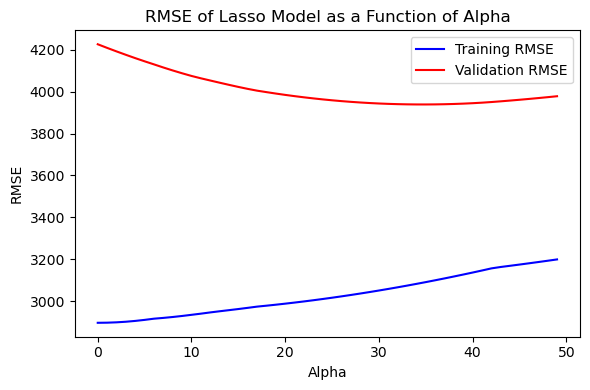

In [23]:
# Create a range of alpha values for tuning
alpha_vals = np.arange(0, 50, 1)

# Intialize lists to store training and validation performance metrics
train_rmse_list = []
val_rmse_list = []

for alpha_val in alpha_vals:
    temp_model = Lasso(alpha = alpha_val)
    temp_model = temp_model.fit(X_train_dummies[features_considered], y_train)
    
    train_preds = temp_model.predict(X_train_dummies[features_considered])
    train_rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = train_preds))
    train_rmse = np.round(train_rmse, 2)
    train_rmse_list.append(train_rmse)

    val_preds = temp_model.predict(X_val_dummies[features_considered])
    val_rmse = np.sqrt(mean_squared_error(y_true = y_val, y_pred = val_preds))
    val_rmse = np.round(val_rmse, 2)
    val_rmse_list.append(val_rmse)

# We will plot the RMSE of the model with the changing alphas
plt.figure(figsize = (6,4))
sns.lineplot(x = alpha_vals, y = train_rmse_list, label = 'Training RMSE', color = 'blue')
sns.lineplot(x = alpha_vals, y = val_rmse_list, label = 'Validation RMSE', color = 'red')
plt.xlabel('Alpha'); plt.ylabel('RMSE')
plt.title('RMSE of Lasso Model as a Function of Alpha')
plt.legend(bbox_to_anchor = (1, 1)); plt.tight_layout();

A good point to note here is that training performance goes down when you regularise, because you are limiting the learning power of the model during training, but the validation performance may improve as you are encouraging generalisation. The validation error here is low around the alpha value of 30

In [24]:
# Obtain the value of lasso alpha for minimum validation MAPE
best_lasso_alpha = alpha_vals[val_rmse_list.index(min(val_rmse_list))]
float(best_lasso_alpha)

35.0

Let's check out the coefficients for this alpha value

In [25]:
temp_model = Lasso(alpha = best_lasso_alpha)
temp_model = temp_model.fit(X_train_dummies[features_considered], y_train)
pd.DataFrame({"Feature": features_considered, "Coefficients - LR": lr_model_1.coef_, "Coefficients - Lasso": temp_model.coef_}).round(2)

,Feature,Coefficients - LR,Coefficients - Lasso
0,symboling_-1,2036.46,0.00
1,symboling_0,2416.82,-0.00
2,symboling_1,2495.54,0.00
3,symboling_2,2039.31,-176.93
4,symboling_3,5501.72,1714.88
5,carbody_hardtop,-1875.36,0.00
6,carbody_hatchback,-6263.59,-2947.93
7,carbody_sedan,-5320.67,-1594.08
8,carbody_wagon,-7573.76,-3809.12
9,wheelbase,15210.12,4340.57


So, here we see for `alpha = 35`, the model dropped 5 features, and the coefficients turned out quite different from the baseline model's

#### Alpha tuning using `GridSearchCV()` - Lasso

Another way to do this in fewer lines of code would be by using `GridSearchCV()` from `sklearn.model_selection` 

This function will search over a 'grid' of parameters, which in this case is simply an array of different alpha values

In [26]:
# List of alphas to tune for Lasso regularisation
param_grid = {'alpha': np.linspace(0.001, 100, 7000)}  # 0.001 to 100, 7000 values

In [27]:
# Initialise Lasso regression model
lasso = Lasso()

# GridSearchCV for tuning Lasso hyperparameters
model_cv = GridSearchCV(estimator=lasso, param_grid = param_grid,
                        scoring = "neg_root_mean_squared_error",
                        cv=5, n_jobs=-1, return_train_score=True, verbose=1)

# Fit the model
model_cv.fit(X_train_dummies, y_train)

# Check number of iterations for convergence
print(model_cv.best_estimator_.n_iter_)

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits
68


Note that `GridSearchCV` scores on negative metrics, meaning a high negative RMSE will indicate a better performance than a lower one (unlike our loop analysis)

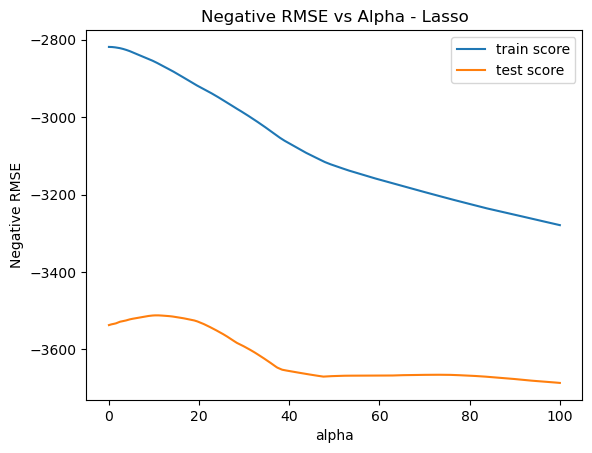

In [28]:
# Convert cross-validation results to DataFrame
cv_results = pd.DataFrame(model_cv.cv_results_)

# Convert alpha to float for better plotting
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# Plot train and test scores against alpha
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative RMSE')

plt.title("Negative RMSE vs Alpha - Lasso")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [29]:
# Best alpha value
best_lasso_alpha = model_cv.best_params_['alpha']
print(f"Best alpha: {best_lasso_alpha}")

# Best score (negative RMSE)
best_score = model_cv.best_score_
print(f"Best negative RMSE: {best_score}")

Best alpha: 10.645271324474923
Best negative RMSE: -3512.1778684340848


In [30]:
best_lasso_model = Lasso(alpha = best_lasso_alpha)
best_lasso_model = best_lasso_model.fit(X_train_dummies[features_considered], y_train)
pd.DataFrame({"Feature": features_considered, "Coefficients - LR": lr_model_1.coef_, "Coefficients - Lasso": best_lasso_model.coef_}).round(2)

,Feature,Coefficients - LR,Coefficients - Lasso
0,symboling_-1,2036.46,220.70
1,symboling_0,2416.82,303.86
2,symboling_1,2495.54,357.78
3,symboling_2,2039.31,-0.00
4,symboling_3,5501.72,3077.24
5,carbody_hardtop,-1875.36,-0.00
6,carbody_hatchback,-6263.59,-4505.36
7,carbody_sedan,-5320.67,-3401.45
8,carbody_wagon,-7573.76,-5664.64
9,wheelbase,15210.12,11045.08


This alpha seems to have dropped only 2 features and also improve the error

Choosing the right `alpha` value is ultimately a judgement call for the data scientist. It requires balancing the trade-off between fitting the training data well and achieving good validation performance, since too large a value can cause underfitting, while too small a value can lead to overfitting.

### Ridge (L2) Regularisation  

Let’s now apply **Ridge regression**, which introduces an L2 penalty to the linear regression model

Unlike Lasso, Ridge does not force coefficients to zero, but instead shrinks them towards zero, helping to reduce model complexity and multicollinearity

In [31]:
lr_model_3 = Ridge(alpha = 1)
lr_model_3 = lr_model_3.fit(X_train_dummies[features_considered], y_train)
y_pred_lr_list = lr_model_3.predict(X_train_dummies[features_considered])

In [32]:
# Compare the coefficients of the unregularised model, lasso and the ridge model
pd.DataFrame({"Feature": features_considered, "Coefficients - LR": lr_model_1.coef_, "Coefficients - Lasso": best_lasso_model.coef_, 
              "Coefficients - Ridge": lr_model_3.coef_}).round(2)

,Feature,Coefficients - LR,Coefficients - Lasso,Coefficients - Ridge
0,symboling_-1,2036.46,220.70,799.52
1,symboling_0,2416.82,303.86,656.43
2,symboling_1,2495.54,357.78,515.29
3,symboling_2,2039.31,-0.00,-189.11
4,symboling_3,5501.72,3077.24,2597.61
5,carbody_hardtop,-1875.36,-0.00,801.34
6,carbody_hatchback,-6263.59,-4505.36,-3653.33
7,carbody_sedan,-5320.67,-3401.45,-2154.97
8,carbody_wagon,-7573.76,-5664.64,-4660.90
9,wheelbase,15210.12,11045.08,5821.31


#### Alpha tuning using `GridSearchCV()` - Ridge

Let's find the optimal alpha for the ridge model using `GridSearchCV()` 

In [33]:
# List of alphas to tune for Ridge regularisation
param_grid = {'alpha': np.linspace(0.0001, 1, 1000)}  # 0.001 to 100, 7000 values

In [34]:
# Initialise Ridge regression model
ridge = Ridge()

# GridSearchCV for tuning Ridge hyperparameters
model_cv = GridSearchCV(estimator=ridge, param_grid = param_grid,
                        scoring = "neg_root_mean_squared_error",
                        cv=5, n_jobs=-1, return_train_score=True, verbose=1)

model_cv.fit(X_train_dummies, y_train)

print(model_cv.best_estimator_.n_iter_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
None


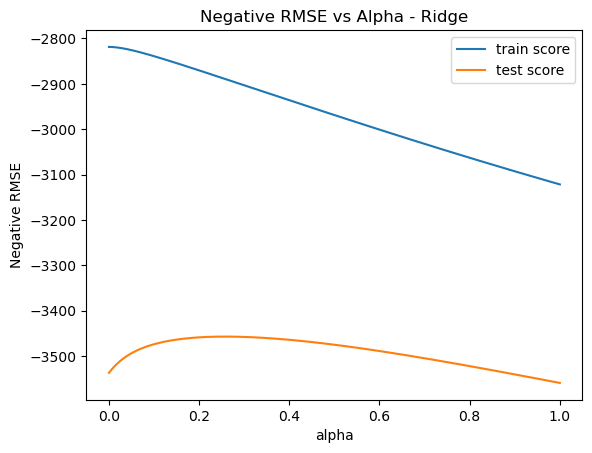

In [35]:
# Convert cross-validation results to DataFrame
cv_results = pd.DataFrame(model_cv.cv_results_)

# Convert alpha to float for better plotting
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# Plot train and test scores against alpha
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative RMSE')

plt.title("Negative RMSE vs Alpha - Ridge")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [36]:
# Best alpha value
best_ridge_alpha = model_cv.best_params_['alpha']
print(f"Best alpha: {best_ridge_alpha}")

# Best score (negative RMSE)
best_score = model_cv.best_score_
print(f"Best negative RMSE: {best_score}")

Best alpha: 0.2573315315315315
Best negative RMSE: -3457.2375014255617


In [37]:
best_ridge_model = Ridge(alpha = best_ridge_alpha)
best_ridge_model = best_ridge_model.fit(X_train_dummies[features_considered], y_train)
pd.DataFrame({"Feature": features_considered, "Coefficients - LR": lr_model_1.coef_, "Coefficients - Lasso": best_lasso_model.coef_, "Coefficients - Ridge": best_ridge_model.coef_}).round(2)

,Feature,Coefficients - LR,Coefficients - Lasso,Coefficients - Ridge
0,symboling_-1,2036.46,220.70,1373.14
1,symboling_0,2416.82,303.86,1376.62
2,symboling_1,2495.54,357.78,1427.07
3,symboling_2,2039.31,-0.00,804.85
4,symboling_3,5501.72,3077.24,3870.58
5,carbody_hardtop,-1875.36,-0.00,-284.79
6,carbody_hatchback,-6263.59,-4505.36,-4784.04
7,carbody_sedan,-5320.67,-3401.45,-3594.03
8,carbody_wagon,-7573.76,-5664.64,-6066.18
9,wheelbase,15210.12,11045.08,9490.57


Ridge is not pushing any coefficients down to zero. Once again, the final choice of alpha depends on you as the data scientist.

Finally, let's visualise the comparison of the best regularised models

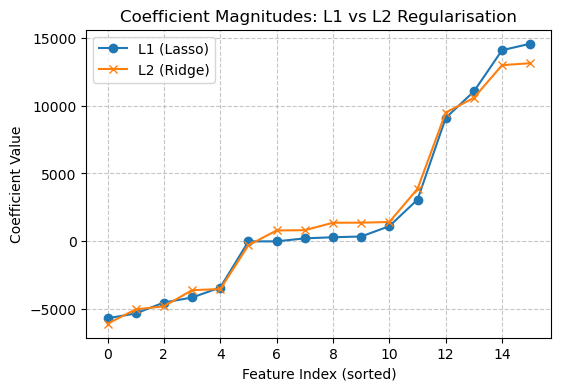

In [38]:
# Coefficients
coef_l1 = best_lasso_model.coef_.flatten()
coef_l2 = best_ridge_model.coef_.flatten()

# Plot coefficient values against feature index
plt.figure(figsize = (6, 4))
plt.plot(np.sort(coef_l1), marker = 'o', label = 'L1 (Lasso)')
plt.plot(np.sort(coef_l2), marker = 'x', label = 'L2 (Ridge)')

plt.title('Coefficient Magnitudes: L1 vs L2 Regularisation'); plt.xlabel('Feature Index (sorted)'); plt.ylabel('Coefficient Value'); plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.7);

Here are the differences between these two regularisation techniques

| Aspect                  | L1 Regularisation (Lasso)              | L2 Regularisation (Ridge)           |
|--------------------------|-----------------------------------------|--------------------------------------|
| Penalty Term            | Sum of absolute values of coefficients | Sum of squared values of coefficients |
| Effect on Coefficients  | Forces some coefficients to exactly 0 (feature selection) | Shrinks coefficients but rarely makes them 0 |
| Model Interpretation    | Produces sparse models, easier to interpret | Retains all features, less sparse |
| When Useful             | High-dimensional data, need feature selection | Multicollinearity, need stability |